In [16]:
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

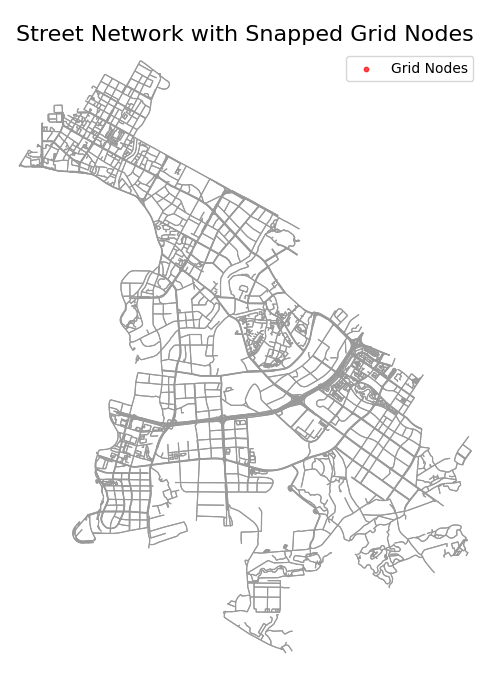

In [44]:
import osmnx as ox
import networkx as nx
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Define the area of interest
place_name = "Jinjiang District, Chengdu, China"

# Load the walking network for the defined area
G = ox.graph_from_place(place_name, network_type='walk')
ox.save_graphml(G, filepath=f"{place_name}_network.graphml")
# G = ox.load_graphml(filepath="chengdu_network.graphml")

# Project the graph to UTM for accurate distance calculations and plotting
G_proj = ox.project_graph(G)

# Get the boundary of the specified area
boundary = ox.geocode_to_gdf(place_name).geometry[0]

# Create a grid of points within the boundary
grid_size = 500  # Grid size in meters
bbox = boundary.bounds  # Get bounding box of the area

x_min, y_min, x_max, y_max = bbox
x_vals = np.arange(x_min, x_max, grid_size)
y_vals = np.arange(y_min, y_max, grid_size)

grid_points = [Point(x, y) for x in x_vals for y in y_vals if boundary.contains(Point(x, y))]

# Snap grid points to the nearest network nodes
grid_nodes = [ox.nearest_nodes(G_proj, point.x, point.y) for point in grid_points]

# # Initialize random 'risk_weight' for each edge
# for u, v, data in G_proj.edges(data=True):
#     data['risk_weight'] = np.random.rand()

# Plot the graph with customized settings
fig, ax = ox.plot_graph(
    G_proj,
    node_size=0,
    edge_color='#999999',
    edge_linewidth=0.8,
    bgcolor='white',
    show=False,
    close=False
)

# Plot the grid nodes on top of the graph
x_coords = [G_proj.nodes[node]['x'] for node in grid_nodes]
y_coords = [G_proj.nodes[node]['y'] for node in grid_nodes]
ax.scatter(
    x_coords,
    y_coords,
    c='red',
    s=10,
    label='Grid Nodes',
    alpha=0.7
)

# Add a legend and title
ax.legend(loc='upper right')
ax.set_title("Street Network with Snapped Grid Nodes", fontsize=16)

# Show the final plot
plt.show()

In [103]:
# Define the area of interest using the bounding box (bbox)
bbox = (30.5493864, 104.057658, 30.6724752, 104.1682525)

# Load the street network within the bounding box
G = ox.graph_from_bbox(north=bbox[2], south=bbox[0], east=bbox[3], west=bbox[1], network_type='drive')


# Define starting and ending points (ensure they're different)
orig_point = (30.5593864, 120.067658)  # Near the bottom-left of bbox
dest_point = (10.6624752, 104.1582525)  # Near the top-right of bbox

# Find the nearest network nodes to the origin and destination points
orig_node = ox.nearest_nodes(G, orig_point[1], orig_point[0])
dest_node = ox.nearest_nodes(G, dest_point[1], dest_point[0])

In [104]:
risk_coeff = 1
for u, v, data in G.edges(data=True):
    # Randomly initialize 'risk_weight'
    data['risk_weight'] = np.random.rand()
    
    # Calculate 'path_weight' as a weighted combination of risk and distance
    data['path_weight'] = risk_coeff * data['risk_weight'] + (1 - risk_coeff) * data['length']

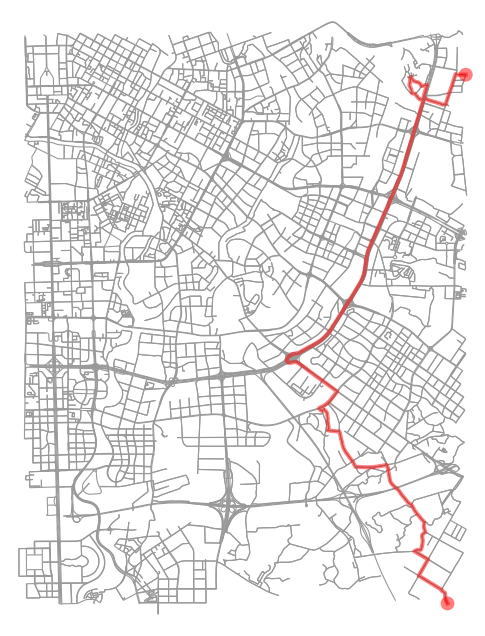

In [105]:

# Compute the shortest path avoiding penalized edges
if orig_node != dest_node:
    safest_route = nx.shortest_path(G, orig_node, dest_node, weight='path_weight')
    shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='length')
    
    # Plot the route on the graph
    fig, ax = ox.plot_graph_route(
        G,
        safest_route,
        node_size=0,
        edge_color='#999999',
        edge_linewidth=0.8,
        route_color='red',
        route_linewidth=3,
        bgcolor='white'
        

    )
else:
    print("Origin and destination nodes are the same; please choose different coordinates.")
